In [1]:
import numpy as np
import matplotlib.pyplot as plt

On génére 1000 valeurs de temps qui varient de 0 a 10 s et on garde le pas qu'on donne : 

In [2]:
tps = np.linspace(0, 10, 1000, retstep = True)
temps = tps[0]
pas = tps[1]

On crée une fonction permettant de générer un signal sinusoïdal dont l'amplitude et la fréquence augmentent en fonction du temps de manière linéaire:

### Signal sinusoïdal

In [3]:
def sinusoidal(temps, amplitude_init, pulsation_init):
    """
    Génére un signal dont l'amplitude et la frequence augmentent en
    fonction du temps de manière linéaire

    Args:
        temps (array): temps
        amplitude_init (float): Amplitude initiale du signal
        pulsation_init (float): Fréquence initiale du signal
    Returs:
        array : signal sinusoïdal
    """
    amplitude = amplitude_init*temps
    pulsation = pulsation_init*temps
    
    signal = amplitude*np.sin(pulsation*temps)
    return signal

On va utiliser cette fonction pour créer un signal sur une plage temporelle d'une seconde avec la même fréquence d'échantillonnage que le tableau de temps généré au début.

Pour ça, on a besoin de générer un tableau de temps qui va de 0 a 1s avec le même pas que dans le tableau de temps précédant :

In [4]:
temps1 = temps[0:100]

On définit l'amplitude et la fréquence initiales de façon que notre signal de 0 a 1s, contienne ~5 passages par un maximum local: 

### Signal mesuré

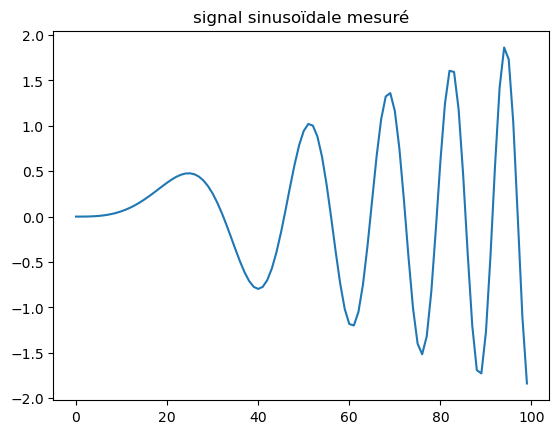

In [5]:
amp_init = 2
puls_init = 30 # en rad/s

signal = sinusoidal(temps1, amp_init, puls_init)
    
plt.plot(signal)
plt.title('signal sinusoïdale mesuré')
plt.show()

### Fréquence d'échantillonnage

La fréquence d'échantillonnage de notre signal est le pas:

In [6]:
print("la fréquence d'échantillonnage est : ", pas, "s")

la fréquence d'échantillonnage est :  0.01001001001001001 s


En Hz (combien de points on a en 1 seconde) :

In [7]:
print("la fréquence d'échantillonnage est : ", 1/pas, "Hz")

la fréquence d'échantillonnage est :  99.9 Hz


Connaissant la fréquence d'échantillonnage, on peut générer un tableau de frequences de Fourier correspondant à notre plage temporelle:

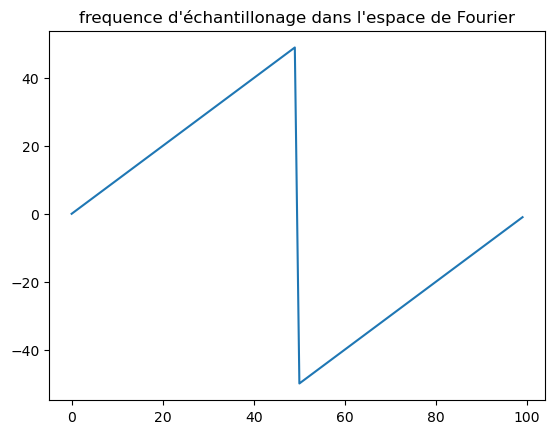

In [8]:
frequence1 = np.fft.fftfreq(np.size(temps1), pas)

plt.plot(frequence1)
plt.title("frequence d'échantillonage dans l'espace de Fourier")
plt.show()

On remarque la forme symétrique de la fonction nécessaire pour calculer la transformée de Fourier numériquement.

### Signal dans l'espace de Fourier

On calcule aussi la transformée de Fourier de notre signal:

In [9]:
signal_fourier = np.fft.fft(signal)

On trace la partie réelle en fonction de la fréquence:

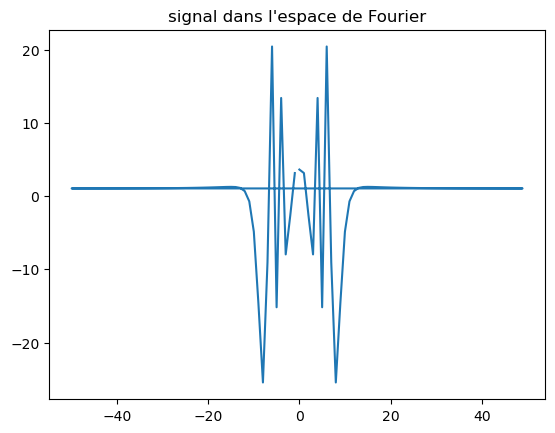

In [10]:
plt.plot(frequence1, np.real(signal_fourier))
plt.title("signal dans l'espace de Fourier")
plt.show()

On remarque encore la forme symétrique.

En utilisant les valeurs de fréquences positives on définit une fonction permettant de générer la densité spectrale de puissance (PSD) d'un bruit coloré sous la forme d'une loi de puissance : 

### Densité spectrale de puissance (PSD) 

In [11]:
def psd(frequence, gamma):
    """
    Calcule la densité spectrale de puissance d'un bruit coloré

    Args:
        frequence (array): frange frequences positives à partir desquelles générer un bruit coloré
        gamma (float): indice loi de puissance

    Returns:
        array : loi de puissance
    """
    p = ((frequence[frequence>0])/10)**(gamma) + 1
    return p

On trace la PSD avec gamma < -1:

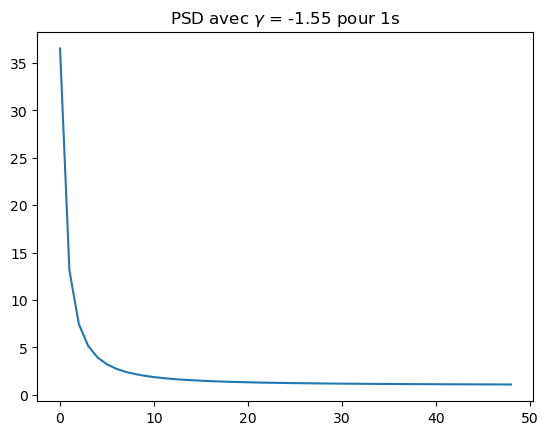

In [12]:
gamma = -1.55
dens1 = psd(frequence1, gamma)
plt.plot(dens1)
plt.title("PSD avec $\gamma$ = -1.55 pour 1s")
plt.show()

C'est la forme attendue d'un bruit coloré dans l'espace de Fourier, i.e, la densité spectrale de puissance d'un bruit coloré. Comme on a vu avant, pour faire la transformée de Fourier inverse, on a besoin (numériquement parlant) que la fonction soit symétrique. C'est pour ça qu'on ajoute le 0 et on "ajoute" la fonction "miroir". On définit une fonction qui fait ça:

In [13]:
def miroir(densite):
    """
    Génére la partie miroir d'une fonction et la rajoute à cette fonction.
    Ajoute aussi le 0.

    Args:
        densite (array): fontion à laquelle on veut ajouter sa partie miroir.

    Returns:
        array : fonction avec partie miroir et 0
    """
    densite = np.insert(densite, 0,  0)
    densite = np.concatenate((densite, np.flip(densite)))
    return densite

On utilise la fonction avec nos données:

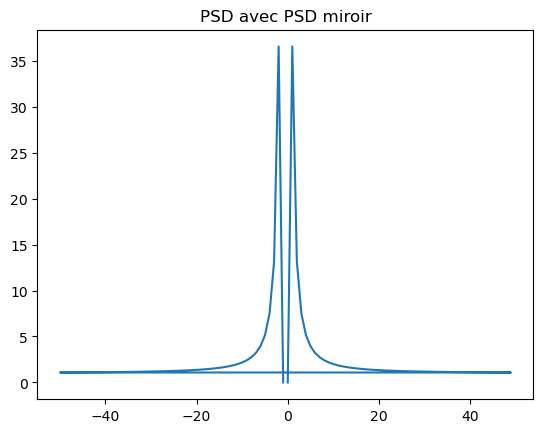

In [14]:
dens1 = psd(frequence1, gamma)
dens1 = miroir(dens1)
plt.plot(frequence1, dens1)
plt.title("PSD avec PSD miroir")
plt.show()

Un fois que l'on a créé un bruit coloré dans l'espace de Fourier, on va créer un autre bruit coloré dans l'espace de Fourier mais avec la "longueur" de toute notre prise de données, i.e. 10 s au lieu de juste 1s :  

### Bruit coloré dans l'espace de Fourier 10s

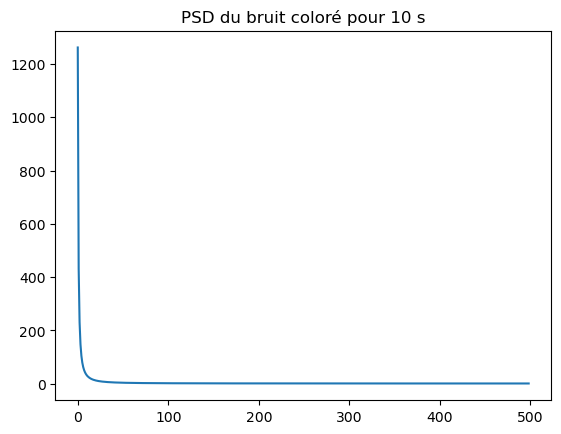

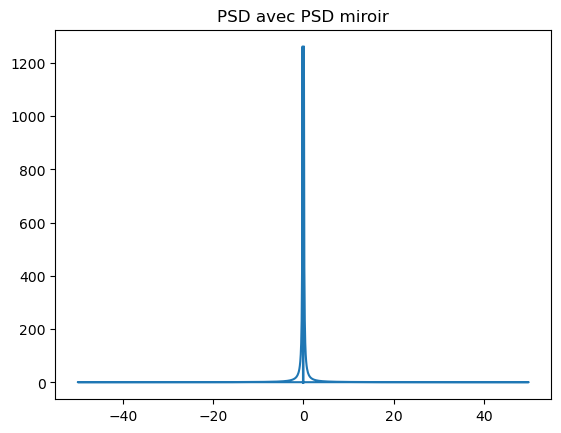

In [15]:
frequence = np.fft.fftfreq(np.size(temps), pas)

dens = psd(frequence, gamma)
plt.plot(dens)
plt.title("PSD du bruit coloré pour 10 s")
plt.show()

dens = miroir(dens)
plt.plot(frequence, dens)
plt.title("PSD avec PSD miroir")
plt.show()

Maintenant il faut passer de l'espace de Fourier à l'espace réel pour obtenir le bruit coloré :

### Bruit coloré dans l'espace réel

In [16]:
def bruit(densite):
    """
    Crée du bruit coloré à partir de sa densité spectrale de puissance.

    Args:
        densite (array): densité spectrale de puissance du bruit coloré dans l'espace de Fourier.

    Returns:
        array : le bruit coloré dans l'espace réel
    """
    bruit_blanc = np.random.normal(0,1,1000)
    fourier_blanc = np.fft.fft(bruit_blanc)
    
    fourier_color = fourier_blanc*np.sqrt(densite)
    bruit_color = np.real(np.fft.ifft(fourier_color))
    
    return bruit_color

On crée une fonction permettant de rajouter le signal de façon aléatoire dans le bruit et comme ça obtenir un vecteur de données simuléees d (données "mesurées" modelisées).

### Signal mesuré avec le bruit correspondante 

In [17]:
pos = np.random.randint(1000-100)

def signalsurbruit(densite, signal, position):
    """
    Introduit un signal dans du bruit coloré

    Args:
        densite (array): densité spectrale de puissance du bruit coloré
        signal (array): signal
        position (int): position où mettre la signal dans le bruit

    Returns:
        array: data : signal + bruit
    """
    bruit_color = bruit(densite)
    bruit_color[position:position+np.size(signal)] += signal
    
    return bruit_color

En utilisant cette fonction on a notre vecteur de données simulées:

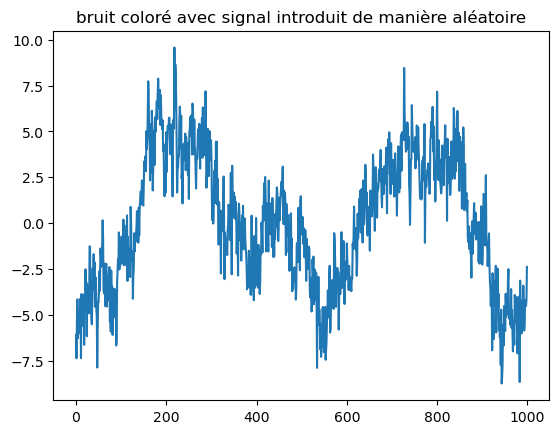

In [18]:
signal_bruit = signalsurbruit(dens, signal, pos)
plt.plot(signal_bruit)
plt.title("bruit coloré avec signal introduit de manière aléatoire")
plt.show()

On essaie une amplitude plus grande pour vérifier qu'on peut voir le signal :

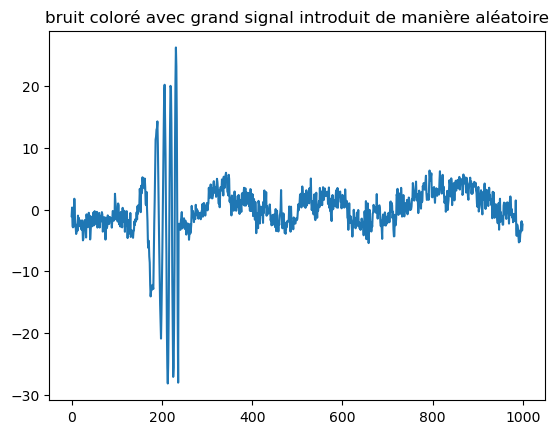

In [19]:
big_amp_init = 30

big_signal = sinusoidal(temps1, big_amp_init, puls_init)

big_signal_bruit = signalsurbruit(dens,big_signal,pos)

plt.plot(big_signal_bruit)
plt.title("bruit coloré avec grand signal introduit de manière aléatoire")
plt.show()

Une fois on a notre signal dans du bruit, on va créer le filtre. Pour ça on a besoin d'un model d'un signal et d'un model du bruit, comme on avait vu avec le signal simple et le bruit blanc gaussien. 

On commence en modélisant un signal de la même manière qu'avant. On peut changer l'amplitude mais la pulsation et les pas entre les points doivent être pareils que le signal "mesuré":

### Signal modelisé

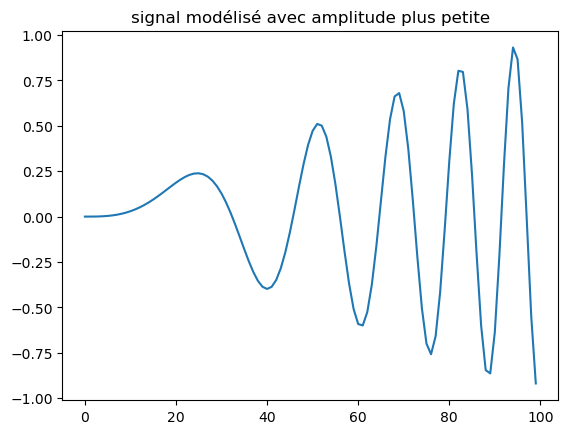

In [20]:
amp_init_model = 1
signal_model = sinusoidal(temps1, amp_init_model, puls_init)

plt.plot(signal_model)
plt.title("signal modélisé avec amplitude plus petite")
plt.show()

Dans ce cas là on a decidé de mettre une amplitude un peu plus grande que celle du signal "mesuré"

### Matrice covariance

Pour modéliser le bruit, on utilise la fonction bruit(densite) pour générer du bruit coloré plusieurs fois afin d'estimer la matrice de covariance du bruit.
On crée une fonction qui calcule l'inverse de la matrice de covariance de 1000 réalisations du bruit en 1s pour l'utiliser comme filtre:

In [21]:
def covariance(densite, temps):
    """
    Calcule l'inverse de la matrice de covariance de 1000 réalisations du bruit en 1 s

    Args:
        densite (array): densité spectrale de puissance du bruit coloré
        temps (array): plage de temps

    Returns:
        array : Matrice de covariance (Cn) et son inverse (cov)
    """
    Cn = np.zeros((100,100))
    for i in range(1000):
        bruit_color = bruit(densite)
        Cn += np.dot(np.transpose(bruit_color[None, 0:100]), bruit_color[None, 0:100])
    Cn /= np.size(temps)
    cov = np.linalg.inv(Cn)
    return cov, Cn

In [22]:
cov, Cn = covariance(dens, temps)

### Test

On vérifie des propiétés de ces matrices: 

In [23]:
if (Cn.all() == np.transpose(Cn).all()):
    print("La matrice de covariance est égale à la matrice de covariance transposée")

La matrice de covariance est égale à la matrice de covariance transposée


In [24]:
I = np.identity(100)
prod = np.dot(Cn,cov)
prod = prod.astype(int)

if prod.all() == I.all():
    print("La matrice de covariance fois son inverse donne l'identité")

La matrice de covariance fois son inverse donne l'identité


### Filtre

Donc, notre filtre devient:

In [25]:
filtre = np.dot(cov, signal_model)

### Filtrage

On définit comme dans la partie du signal simple une fonction qui nous permet de faire le produit scalaire entre le filtre et le vrai signal pour trouver les corrélations croisées entre eux :

In [26]:
def cross(filtr,data):
    """
    Fait le produit scalaire morceau par morceau du temps
    entre le filtre et le signal mesuré (signal + bruit)

    Args:
        filtr (array): filtre
        data (array): signal + bruit

    Returns:
        array : signal filtré
    """
    sizemod = np.size(filtr)
    sizesig = np.size(data)
        
    prod = []
    
    for i in range(sizesig-sizemod):
        p = np.dot(filtr,data[i:(i+sizemod)])
        prod.append(p)
    return prod

On fait les corrélations croisées entre le modèle et les données (signal+bruit):

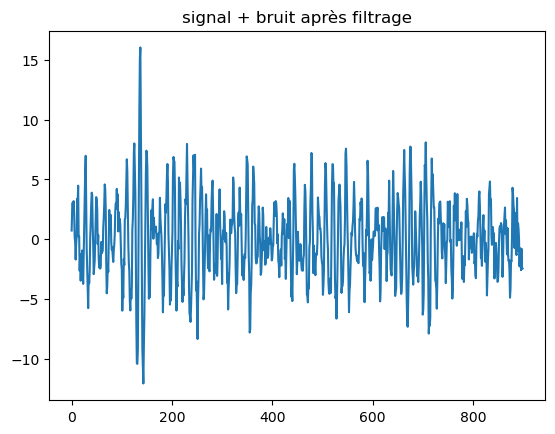

In [27]:
prodat = cross(filtre, signal_bruit)
plt.plot(prodat)
plt.title("signal + bruit après filtrage")
plt.show()

On crée deux fonction pour calculer et plot les 1000 réalisations de bruit filtrés, leur forme et leur deviation standar moyenne:

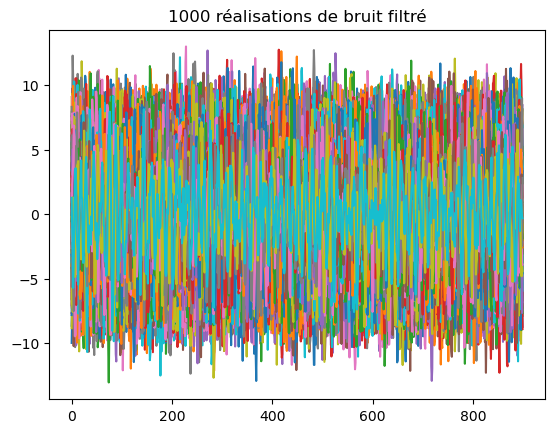

In [28]:
def bruitfiltre(densite,filtre):
    """
    Filtre 1000 réalisations de bruit

    Args:
        densite (array): densité spectrale de puissance
        filtre (array): filtre

    Returns:
        array : (bruit_filtre) bruit filtré en moyenne
        float : (devbr) écart type bruit filtré (1000 réalisations)
    """
    bruit_filtre = np.zeros(900)
    devbr = 0
    for i in range(1000):
        bruit_color = bruit(densite)
        prodbruit = cross(filtre, bruit_color)
        bruit_filtre += prodbruit
        dev = np.std(prodbruit)
        devbr+= dev
    bruit_filtre = bruit_filtre/1000
    devbr = devbr/1000
    return bruit_filtre, devbr

def bruitfiltreplot(densite,filtre):
    """
    Plot les 1000 réalisations de bruit filtré

    Args:
        densite (array): densité spectrale de puissance
        filtre (array): filtre

    Returns:
        array : bruit filtré en moyenne
    """
    plt.figure()
    bruit_filtre = np.zeros(900)
    for i in range(1000):
        bruit_color = bruit(densite)
        prodbruit = cross(filtre, bruit_color)
        plt.title("1000 réalisations de bruit filtré")
        plt.plot(prodbruit)
    plt.show()
    return bruit_filtre
    

bruit_filtre, devbr = bruitfiltre(dens,filtre)
plot_bruit_filtre = bruitfiltreplot(dens,filtre)

### Rapport signal sur bruit (SNR)

Avec la deviation standar du bruit filtré et les données mesurés filtrés on peut maintenant calculer le SNR

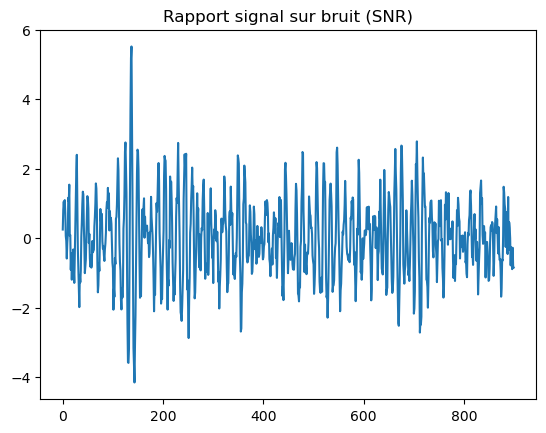

In [29]:
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

### Position signal

On cherche la position du maximum du SNR et on considère une détection si SNR > 3

In [30]:
def position_SNR_max(SNR):
    """
    Cherche la position de la signal avec une sensibilité de SNR > 3

    Args:
        SNR (array): Rapport signal sur bruit
    
    Returns:
        int : position du maximum du SNR s'il est > 3
    """
    
    if np.max(SNR)<3:
        print("Pas de signal détecté")
        return None
    
    index = np.argmax(SNR)
    
    return index

### Position trouvé

Dans la vie réelle on ne saurait pas où se trouve le signal, mais ici on le sait. On peut comparer la position trouvé avec la position où on a introduit le signal et on vérifie que c'est la même:

In [31]:
position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

la position trouvé avec le filtre est :  137
la position aléatoire où on avait mis la signal dans le bruit est :  137


Des fois la position diffère d'un point, c'est parce que notre filtre est un peu plus petit que notre signal, mais la plupart des fois c'est juste.

### Test de $\gamma$

On fait quelques test pour étudier l'impact de la pente $\gamma$ de la PSD de notre bruit sur le SNR de détection de notre signal:

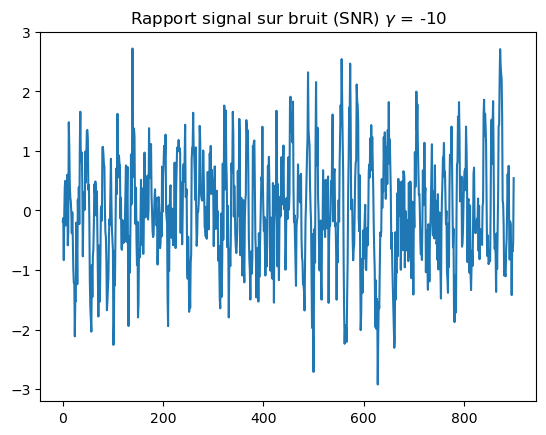

Pas de signal détecté
la position trouvé avec le filtre est :  None
la position aléatoire où on avait mis la signal dans le bruit est :  137


In [32]:
gamma = -10
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = -10")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

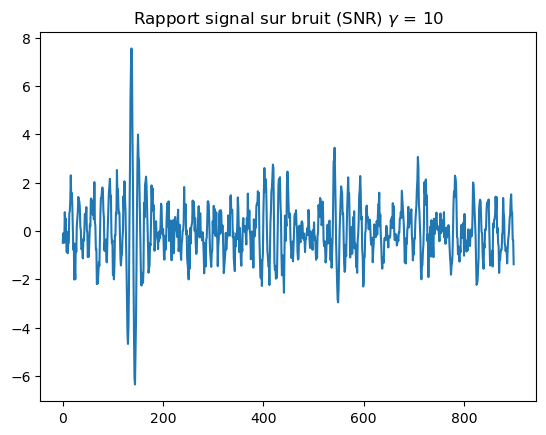

la position trouvé avec le filtre est :  137
la position aléatoire où on avait mis la signal dans le bruit est :  137


In [33]:
gamma = 10
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = 10")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

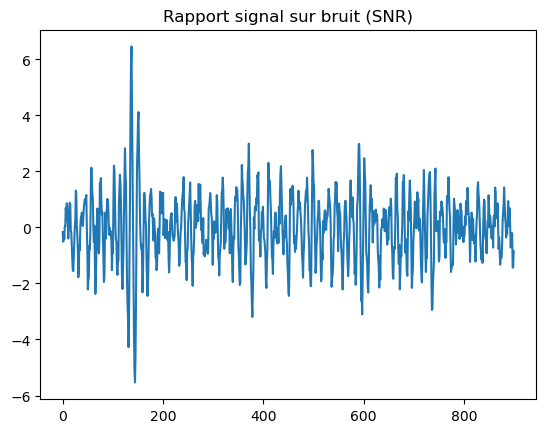

la position trouvé avec le filtre est :  137
la position aléatoire où on avait mis la signal dans le bruit est :  137


In [34]:
gamma = -1
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

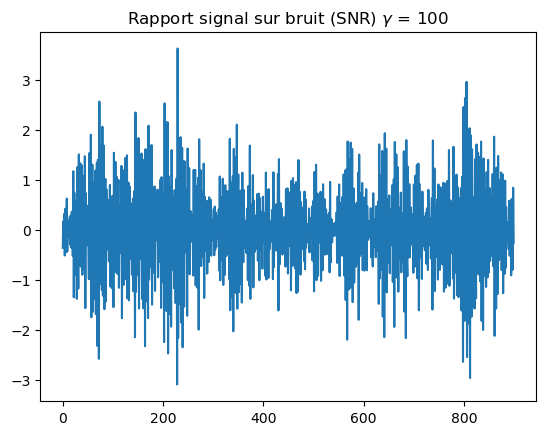

la position trouvé avec le filtre est :  229
la position aléatoire où on avait mis la signal dans le bruit est :  137


In [35]:
gamma = 100
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = 100")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

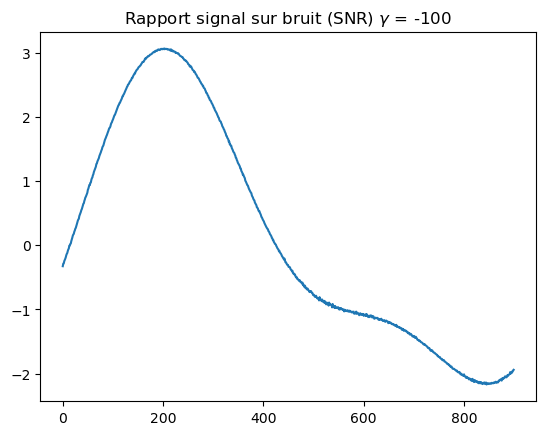

la position trouvé avec le filtre est :  202
la position aléatoire où on avait mis la signal dans le bruit est :  137


In [36]:
gamma = -100
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = -100")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

On remarque que quand $\gamma$ est très loin de -1, vers le haut ou vers le bas, le bruit est très compliqué à être filtré et soit on ne detecte pas le signal, soit on le detecte dans un mauvais endroit.